# RNN with OneHot tensor
Combine three previous achievements.
Still hold off on the stratified split.
This time use tensors instead of numpy arrays.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow import keras
tf.keras.backend.set_floatx('float32')  # was 64, now we're running out of memory. make this 32


Load data from FASTA files.

In [2]:
MIN_SEQ_LEN=200
MAX_SEQ_LEN=25000
DEFLINE='>'
ncfile='ncRNA.fasta' 
pcfile='pcRNA.fasta' 
ncfile='tiny.ncRNA.fasta' # 10 seqs for faster debugging
pcfile='tiny.pcRNA.fasta' 

# Assume file was preprocessed to contain one line per seq.
# Returned structure is ndarray of ndarray i.e no python lists inside.
def load_fasta(filename):
    seqs=[]
    with open (filename,'r') as infile:
        for line in infile:
            if line[0]!=DEFLINE and len(line)>=MIN_SEQ_LEN and len(line)<=MAX_SEQ_LEN:
                line=line.rstrip()
                chars=np.array(list(line))
                seqs.append(chars.reshape(-1, 1)) # reshaped changes (any,) to (any,1)
    nparray=np.array(seqs)
    return nparray

print("Load "+ncfile)
nc_seqs = load_fasta(ncfile)
print("Load "+pcfile)
pc_seqs = load_fasta(pcfile)

Load tiny.ncRNA.fasta
Load tiny.pcRNA.fasta


Encode DNA letters with 4-bit one-hot encoding.

In [3]:
encoder = OneHotEncoder(handle_unknown='ignore',sparse=False)
print("Fit")
#seq=tf.reshape(nc_seqs[0],shape=(-1, 1)) # tensor flow version
seq=nc_seqs[0].reshape(-1, 1)
encoder.fit(seq)
encoder.categories_

Fit


[array(['A', 'C', 'G', 'T'], dtype='<U1')]

In [4]:
encoded=encoder.transform(seq) # returns a numpy.ndarray
print(type(encoded))
encoded

<class 'numpy.ndarray'>


array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]])

In [5]:
print("non-coding")
nc_list=[]
for seq in nc_seqs:
    encoded=encoder.transform(seq)  
    nc_list.append(encoded)
    
nc_all=np.array(nc_list) # .reshape(-1,1)
print("shape: "+str(nc_all.shape))
print("element 0 is a sequence: \n"+str(nc_all[0]))
print("element 0,0 is one letter: "+str(nc_all[0][0]))

non-coding
shape: (10,)
element 0 is a sequence: 
[[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]
element 0,0 is one letter: [0. 0. 0. 1.]


In [6]:
print("protein-coding")
pc_list=[]
for seq in pc_seqs:
    encoded=encoder.transform(seq)
    pc_list.append(encoded)

pc_all=np.array(pc_list) # .reshape(-1,1)
pc_all.shape

protein-coding


(10,)

Add labels. Create train and validation sets.

In [7]:
nc_labels=np.zeros(shape=(17711))
pc_labels=np.ones(shape=(20152))
nc_labels=np.zeros(shape=(10))  # fast debugging
pc_labels=np.ones(shape=(10))

#nc_labeled=np.concatenate((nc_all,nc_labels),axis=1)
#pc_labeled=np.concatenate((pc_all,pc_labels),axis=1)
all_seqs=np.concatenate((nc_all,pc_all),axis=0)
all_labels=np.concatenate((nc_labels,pc_labels),axis=0)

all_seqs.shape,all_labels.shape

((20,), (20,))

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import ShuffleSplit

splitter = ShuffleSplit(n_splits=1, test_size=0.2, random_state=37863)
for train_index,test_index in splitter.split(all_seqs):
    train_seqs =   all_seqs[train_index]
    train_labels = all_labels[train_index]
    test_seqs =    all_seqs[test_index]
    test_labels =  all_labels[test_index]
 
print("train")
print(train_seqs.shape,train_labels.shape)
print("test")
print(test_seqs.shape,test_labels.shape)

train
(16,) (16,)
test
(4,) (4,)


In [9]:
# Now that values are shuffled, partition gives random sample.
PARTITION=25000 # full dataset, TO DO: compute this as % of input
PARTITION=8     # tiny data, fast debugging

X_trainNP=train_seqs[:PARTITION]
X_validNP=train_seqs[PARTITION:]
y_trainNP=train_labels[:PARTITION]
y_validNP=train_labels[PARTITION:]
print("Training Xy data shape:")
print(X_trainNP.shape,y_trainNP.shape)
print("Validation Xy data shape:")
print(X_validNP.shape,y_validNP.shape)
print("train 0 is one sequence: \n"+str(X_trainNP[0]))
print("train 0,0 is one letter: \n"+str(X_trainNP[0][0]))

Training Xy data shape:
(8,) (8,)
Validation Xy data shape:
(8,) (8,)
train 0 is one sequence: 
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
train 0,0 is one letter: 
[0. 0. 1. 0.]


In [10]:
# Side experiment.
# X_trainNP was ( array o seqs ( array of onehot ( array of bits)))
# We need to reshape this to 3D array.
# Try this.
ary_of_ary = np.array([[1,2,3], [4,5,6], [1,2,3], [4,5,6],[1,2,3], [4,5,6],[1,2,3], [4,5,6]])
print(ary_of_ary.shape) 
print(ary_of_ary[0])
b = np.reshape(ary_of_ary, (8, 3, -1)) 
print(b.shape) 

(8, 3)
[1 2 3]
(8, 3, 1)


In [11]:
# The SimpleRNN won't accept our numpy arrays. Here is the error.
# ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

# For variable length sequences, it seems we must use a TensorFlow Ragged Tensor, which is much slower.
# https://www.tensorflow.org/guide/tensor#ragged_tensors

X_train = tf.ragged.constant(X_trainNP)  # This takes a long time and hogs memory
print(type(X_train))
print(X_train.shape)
y_train = tf.convert_to_tensor(y_trainNP)
print(type(y_train))
print(y_train.shape)
X_valid = tf.ragged.constant(X_validNP)
print(type(X_valid))
print(X_valid.shape)
y_valid = tf.convert_to_tensor(y_validNP)
print(type(y_valid))
print(y_valid.shape)

# This page offers a speedup for a slightly different problem and I cannot understand it.
# https://stackoverflow.com/questions/44353509/tensorflow-tf-constant-initializer-is-very-slow

# https://www.tensorflow.org/api_docs/python/tf/RaggedTensor#documenting_raggedtensor_shapes_2
# For example, the shape of a 3-D RaggedTensor that stores the fixed-size word embedding for each word in a sentence, for each sentence in a batch, could be written as [num_sentences, (num_words), embedding_size].

# We are seeing <class 'tensorflow.python.ops.ragged.ragged_tensor.RaggedTensor'> (8, None, None, None)
# Why do we get a 4D tensor for X? We need a 3D tensor for X and y.

<class 'tensorflow.python.ops.ragged.ragged_tensor.RaggedTensor'>
(8, None, None)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(8,)
<class 'tensorflow.python.ops.ragged.ragged_tensor.RaggedTensor'>
(8, None, None)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(8,)


In [12]:
seq_len=None  # none indicates variable length
input_features=4  # one hot encoding of DNA means 4 categories
rnn2 = keras.models.Sequential([
    keras.layers.SimpleRNN(4, return_sequences=True, input_shape=[seq_len,input_features]),
    keras.layers.SimpleRNN(1),
])
bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
rnn2.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
rnn2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 4)           36        
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 1)                 6         
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = rnn2.fit(X_train,y_train,epochs=5,validation_data=(X_valid,y_valid))
# ValueError: Input 0 of layer sequential_1 is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: [None, None, None, None]

Epoch 1/5
1/1 [==============================] - 2s 2s/step - loss: 0.1208 - accuracy: 1.0000 - val_loss: 2.2261 - val_accuracy: 0.6250
Epoch 2/5
1/1 [==============================] - 1s 1s/step - loss: 0.0894 - accuracy: 1.0000 - val_loss: 2.1831 - val_accuracy: 0.7500
Epoch 3/5
1/1 [==============================] - 1s 988ms/step - loss: 0.0815 - accuracy: 1.0000 - val_loss: 2.1550 - val_accuracy: 0.7500
Epoch 4/5
1/1 [==============================] - 1s 983ms/step - loss: 0.0853 - accuracy: 1.0000 - val_loss: 2.1369 - val_accuracy: 0.8750
Epoch 5/5
1/1 [==============================] - 1s 797ms/step - loss: 0.0879 - accuracy: 1.0000 - val_loss: 2.1261 - val_accuracy: 0.8750


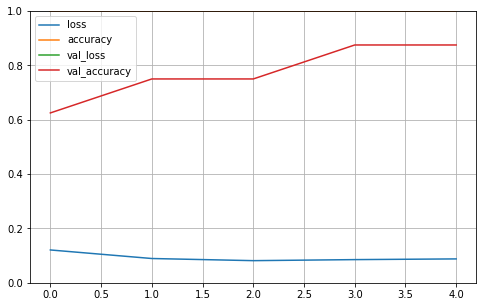

In [14]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()